# Using Maps and Geo-data to identify the ideal implantation for a new super marker in Brussels.

### Intro

In this blog, we will have :
- Scrap a dynamic website to extract geographical position of super markets in the city of Brussels
- Cleanup the extracted data to avoid duplications from several lists (based on distance information)
- Compute the center of mass of the shops and use this to center a map
- Draw the shop position on a map
- Use the OSRM API and public server to compute the travel time (by car) between a specific point and all identified shops
- Make a map of shop coverage, by coloring area according to the brand of the closest (in time) shop
- Make a map of the travel time to the closest shop  (in order to identify area that are far from existing shops)

Putting all together, we will be able to identify the best implentation to open a new shop of a given brand.


### Typical imports

Nothing very special here.

In [2]:
#needed for general operations
import os, operator, time, random 

#needed for mathematical operations or drawing
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#needed for http dialog with RESTful API
import json
import urllib3
http = urllib3.PoolManager()

#needed for browser emulation (dynamic page scrapping) in hidden window
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from pyvirtualdisplay import Display

#needed for web page mining
from bs4 import BeautifulSoup

#needed for address to coordinate conversions and distance computations
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
geolocator = Nominatim()

#needed to display map widget in notebook
from ipyleaflet import Map,DrawControl, Circle, Rectangle, CircleMarker, LayerGroup, Marker

### Building a module to extract data from the Pagesdor web site.

As the webpage are dynamically generated via javascrips, we are using Selenium to emulate a firefox browser while navigating on the pages d'or website.  Also, only the 20 first results are loaded on the page by default.  So we need to press a button to load following results until everything is loaded.  The rest of the code is traditional beautifulSoup parsing.

In [ ]:
def getPagesdorData(driver, topic, city):
    url = "http://www.pagesdor.be/qn/business/advanced/where/"+city+"/what/"+topic+"/"
    print("processing %s" % url)
    driver.get(url)
    
    while(True): #click next button until all elements are loaded on the page
        try:
            nextElemButton = driver.find_element_by_css_selector(".-next-result")
            if(nextElemButton.is_displayed()):
                nextElemButton.click()
                print("   - load next results")
            else: break
        except: break

    resultsElem = driver.find_element_by_css_selector(".cst-results")
    resultsHTML = resultsElem.get_attribute("innerHTML")
    resultsBS   = BeautifulSoup( resultsHTML , "lxml")   
    results = resultsBS.body.find_all(class_="-result list-item", recursive=True)  #get the block corresponding to each results
    data = []
    for result in results:    
        fields = result.find_all(class_="row-fluid", recursive=True)
        Name = fields[0].find_all("a")[1].get_text("", strip=True)      
        Address = fields[1].get_text("", strip=True)
        dic = {"name":Name, "address":Address}
        data += [dic]        
    return data  

### Scrapping data for super markets in Brussels area

- We use pyvirtualdisplay to emulate a display where the Selenium fake firefox browser can live
- We then scrap pages d'or super marker data for each town zip code in brussels (data are aggregated into a single array)
- We can then turn off the virtual display

In [ ]:
os.environ["PATH"] += ":/home/loicus/Data/Soft/geckodriver"
display = Display(visible=0, size=(1024, 768))
display.start()
driver = webdriver.Firefox()
driver.implicitly_wait(10) # seconds

data = []
data += getPagesdorData(driver, "super marché"     , "1000" ) 
data += getPagesdorData(driver, "super marché"     , "1030" ) 
data += getPagesdorData(driver, "super marché"     , "1040" ) 
data += getPagesdorData(driver, "super marché"     , "1050" ) 
data += getPagesdorData(driver, "super marché"     , "1060" ) 
data += getPagesdorData(driver, "super marché"     , "1070" ) 
data += getPagesdorData(driver, "super marché"     , "1080" ) 
data += getPagesdorData(driver, "super marché"     , "1081" ) 
data += getPagesdorData(driver, "super marché"     , "1082" ) 
data += getPagesdorData(driver, "super marché"     , "1083" ) 
data += getPagesdorData(driver, "super marché"     , "1090" ) 
data += getPagesdorData(driver, "super marché"     , "1140" ) 
data += getPagesdorData(driver, "super marché"     , "1150" ) 
data += getPagesdorData(driver, "super marché"     , "1160" ) 
data += getPagesdorData(driver, "super marché"     , "1170" ) 
data += getPagesdorData(driver, "super marché"     , "1180" ) 
data += getPagesdorData(driver, "super marché"     , "1190" ) 
data += getPagesdorData(driver, "super marché"     , "1200" ) 
data += getPagesdorData(driver, "super marché"     , "1210" ) 
data += getPagesdorData(driver, "super marché"     , "1700" ) #add dilbeek
    
driver.quit()
display.stop()            

processing http://www.pagesdor.be/qn/business/advanced/where/1000/what/super marché/
   - load next results
processing http://www.pagesdor.be/qn/business/advanced/where/1030/what/super marché/
   - load next results
processing http://www.pagesdor.be/qn/business/advanced/where/1040/what/super marché/
   - load next results
processing http://www.pagesdor.be/qn/business/advanced/where/1050/what/super marché/
   - load next results
processing http://www.pagesdor.be/qn/business/advanced/where/1060/what/super marché/
   - load next results
processing http://www.pagesdor.be/qn/business/advanced/where/1070/what/super marché/
   - load next results
processing http://www.pagesdor.be/qn/business/advanced/where/1080/what/super marché/
   - load next results
processing http://www.pagesdor.be/qn/business/advanced/where/1081/what/super marché/
   - load next results
processing http://www.pagesdor.be/qn/business/advanced/where/1082/what/super marché/
   - load next results
processing http://www.pagesd

### Data cross-cleaning

- We keep only super market that are in the four main brands in Belgium: Delhaize, Carrefour, Colruyt and Lidl
- We define a color code for these 4 brands  (Red, Blue, Orange and Yellow, respectively)
- We compute the GPS coordinates from the adress of the shop (using the geopy geolocator)
- We make sure that all shops in our list are distant from each other by at least 10m.  (This is to avoid counting the same shop twice).
- We count the number of identified shops

In [ ]:
colorMap = {"Delhaize":"red", "Carrefour":"blue", "Colruyt":"DarkOrange", "Lidl":"yellow"}

cleanedData = []
for d in data: 
    if  ("delhaize"  in d["name"].lower()):d["brand"] = "Delhaize"
    elif("lidl"      in d["name"].lower()):d["brand"] = "Lidl"
    elif("colruyt"   in d["name"].lower()):d["brand"] = "Colruyt"
    elif("carrefour" in d["name"].lower()):d["brand"] = "Carrefour"
    else: continue
        
    loc = geolocator.geocode(d["address"])
    if(not loc): continue
    d["coord"] = [loc.latitude, loc.longitude]

    minDist=1e99
    for d2 in cleanedData:             
        dist = great_circle(d["coord"], d2["coord"]).meters
        if(dist<minDist): minDist = dist

    if(minDist>10): #only consider shops that aren't too close to avoid duplicates
        cleanedData += [d]
        
data = cleanedData
len(data)

### Shops center of mass

- We compute the center of mass of our shop clouds  (using even weight for each shop)
- We will use this to center the map 

In [ ]:
averageLat = 0.0
averageLon = 0.0
averageCnt = 0
for d in data: 
    averageLat+=d["coord"][0]
    averageLon+=d["coord"][1]
    averageCnt+=1
    
averageLat /= averageCnt   
averageLon /= averageCnt   

### Maps

- We create three maps centered on the shop clouds
- We fix the zoop level to a proper range
- We don't display the maps here.  (will me drawn later on)

In [ ]:
m0 = Map(center=[averageLat, averageLon], zoom=13)
m0.scroll_wheel_zoom =False

m1 = Map(center=[averageLat, averageLon], zoom=13)
m1.scroll_wheel_zoom =False

m2 = Map(center=[averageLat, averageLon], zoom=13)
m2.scroll_wheel_zoom =False

### Shop location

- We draw shop locations on the Maps using circle marker.
- The marker color is chosen according to the shop brand.

In [ ]:
for d in data:
    if("coord" not in d or d["coord"]==None):continue
    color=colorMap.get(d["brand"], "black")
    c = Circle(location=d["coord"], radius=50, weight=1, fill_opacity=1.0, fill_color=color, color="black")
    #c = Marker(location=d["coord"], title=d["brand"], rise_offset=100, fill_color=color, color=color)
    m0.add_layer(c)
    m1.add_layer(c)
    m2.add_layer(c)    

In [ ]:
m0

### Color Legend

- We use matplotlib to get the color legend associated to the brands

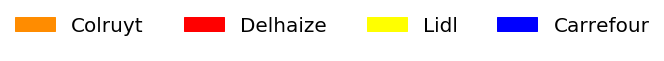

In [9]:
%matplotlib inline

labels = list(colorMap.keys())
colors = list(colorMap.values())

plt.figure(figsize=(8, 0.5))
legpatches = [ patches.Patch(color=color, label=label) for label, color in zip(labels, colors)]
plt.legend(legpatches, labels, loc='center', frameon=False, ncol=4, prop={'size':20})
plt.axis('off')
plt.show()

### OSRM helper function

- We create a helper function to compute OSRM time distance between points
- This is based on a RESTful API deployed on the OSRM public server (free of charge, but without SLA)
- The GET URL contains the list of GPS coordinates to evaluate
- The Response is a JSON containing the distance matrix between sources and destiations
- The number of points that we can test by request is limited, so there is a function to chunk our data in smaller pieces in order to do the computation per bunch
- Function output is a vector containing the tested cell, the time to closest shop and the closest shop itself

In [10]:

def getRoutesChunk(data, cells):        
    url = 'http://router.project-osrm.org/table/v1/driving/'
    count=0
    sources  = []
    goodData = []
    for index,d in enumerate(data):
        if("coord" not in d):continue        
        if(index!=0): url+=";"            
        url      += "%.8f,%.8f" % (d["coord"][1],d["coord"][0])
        goodData +=[d]    
        count    +=1;
      
    for index,cell in enumerate(cells):
        center   = ( (cell[1][1]+cell[0][1])*0.5 , (cell[1][0]+cell[0][0])*0.5 )
        url     +=";"
        url     += "%.8f,%.8f" % (center[0], center[1])
        sources +=[count]                
        count   +=1;

    url += "?sources="   
    for index,source in enumerate(sources):
        if(index!=0): url+=";"
        url  += str(source)    
        
    request  = http.request('GET', url)
    if(request.status!=200):
        print("bad response: %s" % str(request.status) )
        return []
    
    response = json.loads( request.data.decode('utf8'))
    request.release_conn()
    #print( json.dumps(response, sort_keys=True, indent=3) )

    toReturn = []
    cellTimes = response["durations"]                    
    for index,cellTime in enumerate(cellTimes): 
        timeToData = cellTime[:len(goodData)]
        min_index, min_time = min(enumerate(timeToData), key=operator.itemgetter(1))    
        toReturn += [ (cells[index],min_time,goodData[min_index]) ]
                
    return toReturn

def getRoutes(data, cells, chunkSize=50):
    chunkCells = (cells[i:i+chunkSize] for i in range(0, len(cells), chunkSize))
    toReturn = []
    for chunk in chunkCells:
        toReturn += getRoutesChunk(data, chunk)
    return toReturn    

### Cell Grids 

- We split the map into a grid of cells
- The finner the grid, the higher the resolution but the slower the computation


In [11]:
NedgesX = 150
NedgesY = 75
boundX = 0.1700
boundY = 0.0500
edgeX = boundX/NedgesX
edgeY = boundY/NedgesY
cells = []
for i in range(0,NedgesY):
    for j in range(0,NedgesX):
        y = averageLat - boundY*0.5 + i*edgeY
        x = averageLon - boundX*0.5 + j*edgeX
        cells += [ [(y, x), (y+edgeY, x+edgeX)] ]        

### Compute Cells
- for each cells we compute the time distance to shop using OSRM helper functions

In [16]:
results = getRoutes(data, cells, 50)

### Display cells on map

- We display each cell on the maps (either according to brand of closest shop or according to the time to the closest shop)

In [ ]:
for (cell,time,closest) in results:
    color=colorMap.get(closest["brand"], "black")
    r1 = Rectangle(bounds=cell, weight=0, fill_opacity=0.40, fill_color=color, color=color)        
    m1.add_layer(r1)
        
    color = matplotlib.colors.rgb2hex( np.array([1.0, 0.0, 0.0]) + max(0,min(1,time/300.0)) * np.array([0.0, 1.0, 1.0]) )
    r2 = Rectangle(bounds=cell, weight=0, fill_opacity=0.60, fill_color=color, color=color)
    m2.add_layer(r2)        

### We display the map

- finaly!

In [17]:
m1

In [18]:
m2

### Identify the best place for a new shop

- We can see that there is a large area in the north-west of Anderlecht where there are currently no shops and where the travel time to the closest shop is therefore quite large (>5min)
- This area is currently shared among Carrefour, Delhaize and Colruyt,  so Lidl would be smart to implement a new shop there.

# What's next

- We should correlate these information with immo-data in order to find a good location/price commercial surface for renting
- We should correlate there information with census data in order to open the shop in high population density area
- We should redo these maps with different new shop implantation hypothesis and see how much these choice would impact the competitors 
- Etc... As usual so many things can be done from there

# Do you need help with your next shop business  ?
Feel free to contact me, we'd be happy to help